In [1]:
# Tarification Non-Vie - Notebook Jupyter

# Cellule 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import warnings
warnings.filterwarnings("ignore")




In [2]:

# Activer la conversion R → pandas
pandas2ri.activate()

#Installation des packages de base de R
utils = importr('utils')
#base = importr('base')

utils.chooseCRANmirror(ind=1)
utils.install_packages('CASdatasets')

cas=importr('CASdatasets')


#Les variables de type factor (par ex. VehBrand, VehGas, etc.) sont codées en entiers en R, mais leur affichage dépend des labels.

#Si on les importe directement, rpy2 importe les entiers sans les labels → d’où les noms en chiffres que tu vois.

#Le fait de les convertir en chaînes de caractères (as.character) dans R permet de préserver les labels textuels dans pandas.

robjects.r('data(freMTPL2freq)')
robjects.r('data(freMTPL2sev)')
robjects.r('freMTPL2freq[] <- lapply(freMTPL2freq, function(x) if (is.factor(x)) as.character(x) else x)')
robjects.r('freMTPL2sev[] <- lapply(freMTPL2sev, function(x) if (is.factor(x)) as.character(x) else x)')


# Récupérer l’objet freMTPL

df_freq= robjects.r('freMTPL2freq')
df_sev=robjects.r('freMTPL2sev')

# Le convertir en DataFrame pandas

df = pandas2ri.rpy2py(df_freq)
d_sev=pandas2ri.rpy2py(df_sev)


# Vérification des polices uniques et communes
results = []

unique_policies = df['IDpol'].nunique()
results.append(["Polices uniques dans df", unique_policies])

common_policies = set(d_sev['IDpol']).intersection(set(df['IDpol']))
results.append(["Polices communes entre d_sev et df", len(common_policies)])

# Création du DataFrame pour afficher les résultats sous forme de table
df_results = pd.DataFrame(results, columns=["Vérification", "Valeur"])
print(df_results)

##6 polices n'ont pas de caractéristiques dans la table principale
TotalClaim_b=d_sev['ClaimAmount'].sum()
non_common_policies = d_sev[~d_sev['IDpol'].isin(df['IDpol'])]
d_sev = d_sev[d_sev['IDpol'].isin(df['IDpol'])]
##Multiples lignes pour une police dans sev
sev=d_sev.groupby("IDpol").agg(ClaimAmount=("ClaimAmount","sum"),
                         Claimsevnb=("IDpol","count")).reset_index()

TotalClaim_a=d_sev['ClaimAmount'].sum()

TotalClaim_a/TotalClaim_b

data= pd.merge(df,sev,on="IDpol",how="outer")
data['ClaimAmount'].fillna(0, inplace = True)
data['Claimsevnb'].fillna(0, inplace = True)


Exception ignored from cffi callback <function _consolewrite_ex at 0x000001BECCB41DA0>:
Traceback (most recent call last):
  File "C:\Users\Utilisateur\anaconda3\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 136, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Utilisateur\anaconda3\Lib\site-packages\rpy2\rinterface_lib\conversion.py", line 152, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 107: invalid continuation byte
R[write to console]: In addition: 
R[write to console]: Warning message:

Exception ignored from cffi callback <function _consolewrite_ex at 0x000001BECCB41DA0>:
Traceback (most recent call last):
  File "C:\Users\Utilisateur\anaconda3\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", 

                         Vérification  Valeur
0             Polices uniques dans df  678013
1  Polices communes entre d_sev et df   24944


In [3]:
# Cellule 2: Chargement des données
data = data.drop(columns=["Unnamed: 0", "IDpol"], errors='ignore')
data = data[data["Exposure"] > 0].copy()
data["PurePremium"] = data["ClaimAmount"] / data["Exposure"]



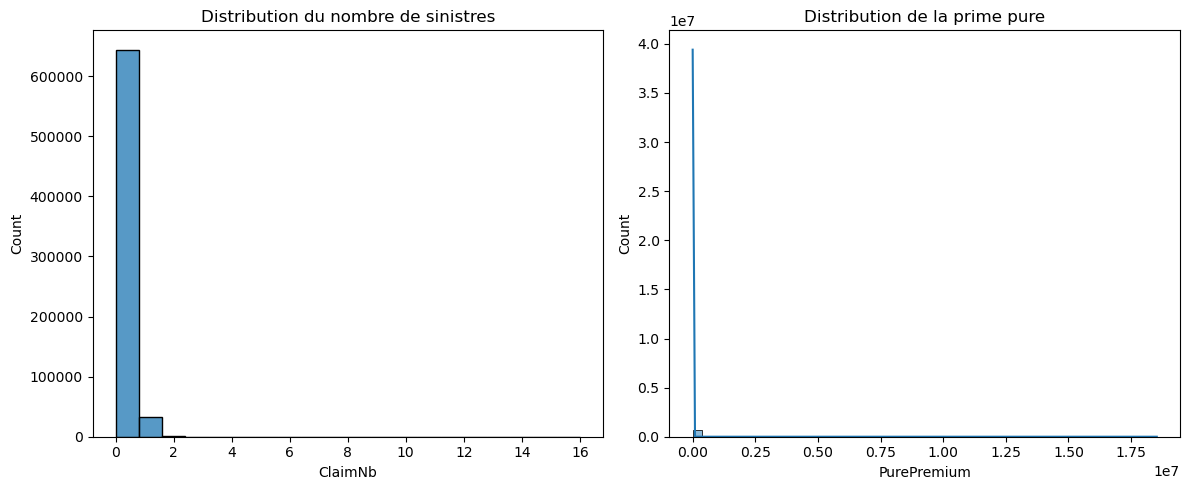

In [4]:
# Cellule 3: Exploration des données
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data['ClaimNb'], bins=20, kde=False, ax=axs[0])
axs[0].set_title("Distribution du nombre de sinistres")
sns.histplot(data['PurePremium'], bins=50, kde=True, ax=axs[1])
axs[1].set_title("Distribution de la prime pure")
plt.tight_layout()
plt.show()



In [5]:
# Cellule 4: Encodage des variables catégorielles
cat_vars = ["VehBrand", "VehGas", "Area", "Region"]
data_encoded = pd.get_dummies(data, columns=cat_vars, drop_first=True)


In [6]:

# Cellule 5: Définition des features
features = [col for col in data_encoded.columns if col not in ["ClaimAmount", "ClaimNb", "Exposure", "Claimsevnb", "PurePremium"]]
X = data_encoded[features]
y = data_encoded["PurePremium"]



In [7]:
# Cellule 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [8]:
# Cellule 7: Modèle XGBoost
xgb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nRMSE : {rmse:.2f} - MAE : {mae:.2f}")



TypeError: Feature names are only supported if all input features have string names, but your input has ['str', 'str_'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [ ]:
# Cellule 8: Graphique d’importance des variables
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances[:15].plot(kind='barh')
plt.title("Top 15 variables importantes")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [ ]:
# Cellule 9: GLM Poisson (fréquence)
y_freq = data_encoded["ClaimNb"]
data_encoded["log_Exposure"] = np.log(data_encoded["Exposure"])
X_glm = sm.add_constant(X)
glm_poisson = sm.GLM(y_freq, X_glm, offset=data_encoded["log_Exposure"], family=sm.families.Poisson()).fit()
print(glm_poisson.summary())